In [23]:
import torch
print("Torch Version: {}".format(torch.__version__))

Torch Version: 1.8.1


In [25]:
import numpy as np
print("Numpy Version: {}".format(np.__version__))

Numpy Version: 1.19.2


In [27]:
import matplotlib
print("Matplotlib Version: {}".format(matplotlib.__version__))

Matplotlib Version: 3.3.2


In [29]:
import torchvision 
print("Torchvision Version: {}".format(torchvision.__version__))

Torchvision Version: 0.9.1


In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets,transforms
from torch.utils.data.sampler import SubsetRandomSampler

%matplotlib inline
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [33]:
batch_size = 20

valid_size = 0.2

transform = transforms.Compose([
    transforms.ToTensor(),         
    transforms.Normalize((0.5), (0.5,))
    ])

train_data = datasets.MNIST('MNIST_data', train=True, download=True, transform=transform)

test_data = datasets.MNIST('MNIST_data', train=False, download=True, transform=transform)

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)

valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

test_loader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)

  def forward(self, x):
    x = x.view(x.shape[0], -1)  # flattering the input tensor
    
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x), dim=1)

    return x

In [32]:
model = Classifier()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.003)

In [36]:
epochs = 30
train_losses, valid_losses = [], []
valid_loss_min = np.Inf

for e in range(epochs):
    train_loss, valid_loss = 0.0, 0.0
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    
    model.eval
    for images, labels in valid_loader:
        images, labels = images.to(device), labels.to(device)

        output = model(images)
        loss = criterion(output, labels)
        valid_loss += loss.item()*images.size(0)

    
    train_loss = train_loss/len(train_loader.sampler)
    train_losses.append(train_loss)
    valid_loss = valid_loss/len(valid_loader.sampler)
    valid_losses.append(valid_loss)

    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        e+1, train_loss, valid_loss))

    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'mnist_ann.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.331936 	Validation Loss: 0.316636
Validation loss decreased (inf --> 0.316636).  Saving model ...
Epoch: 2 	Training Loss: 0.303024 	Validation Loss: 0.296594
Validation loss decreased (0.316636 --> 0.296594).  Saving model ...
Epoch: 3 	Training Loss: 0.278292 	Validation Loss: 0.267787
Validation loss decreased (0.296594 --> 0.267787).  Saving model ...
Epoch: 4 	Training Loss: 0.255892 	Validation Loss: 0.249430
Validation loss decreased (0.267787 --> 0.249430).  Saving model ...
Epoch: 5 	Training Loss: 0.234609 	Validation Loss: 0.236686
Validation loss decreased (0.249430 --> 0.236686).  Saving model ...
Epoch: 6 	Training Loss: 0.214459 	Validation Loss: 0.216773
Validation loss decreased (0.236686 --> 0.216773).  Saving model ...
Epoch: 7 	Training Loss: 0.196832 	Validation Loss: 0.212171
Validation loss decreased (0.216773 --> 0.212171).  Saving model ...
Epoch: 8 	Training Loss: 0.180280 	Validation Loss: 0.181335
Validation loss decreased (0.21217

In [37]:
model.load_state_dict(torch.load('mnist_ann.pt', map_location=torch.device(device)))

<All keys matched successfully>

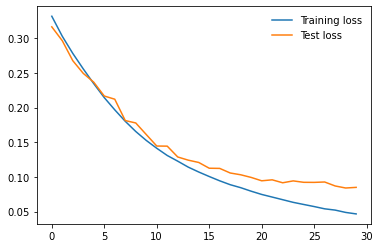

In [39]:
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label ='Test loss')
plt.legend(frameon=False)
plt.show()

In [56]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() 

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    output = model(images)
    loss = criterion(output, labels)
    test_loss += loss.item()*images.size(0)
    _, pred = torch.max(output, 1)
    correct = np.squeeze(pred.eq(labels.data.view_as(pred)))
    
    for i in range(batch_size):
        label = labels.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1


test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %2s: %2d%% (%2d/%2d)' % (
            str([i]), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.082571

Test Accuracy of [0]: 98% (966/980)
Test Accuracy of [1]: 99% (1125/1135)
Test Accuracy of [2]: 97% (1006/1032)
Test Accuracy of [3]: 97% (987/1010)
Test Accuracy of [4]: 96% (952/982)
Test Accuracy of [5]: 97% (871/892)
Test Accuracy of [6]: 97% (936/958)
Test Accuracy of [7]: 95% (980/1028)
Test Accuracy of [8]: 97% (948/974)
Test Accuracy of [9]: 96% (978/1009)

Test Accuracy (Overall): 97% (9749/10000)


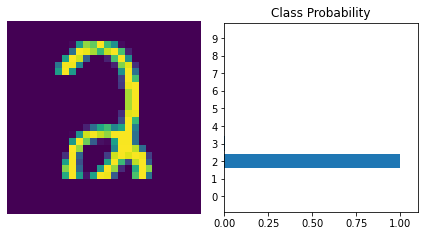

In [77]:
images, labels = next(iter(train_loader))
image, labels = images.to(device), labels.to(device)

img = images[1].view(1,784)

with torch.no_grad():
  log_ps = model(img)

ps = F.softmax(log_ps, dim=1)
fig = plt.figure(figsize=(6,9))
ax1 = plt.subplot(121)
ax1.imshow(img.resize_(1, 28, 28).cpu().numpy().squeeze())
ax1.axis('off')

ax2 = plt.subplot(122)
ax2.set_yticks(np.arange(10))
ax2.set_xticks(np.arange(0,1.1,0.25))
ax2.set_xlim(0,1.1)
ax2.set_aspect(0.1)
ax2.set_title('Class Probability')
plt.barh(np.arange(10),ps.data.cpu().numpy().squeeze())

plt.tight_layout()
